In [1]:
from utils.shuqing_all import *

In [2]:
!pip3 install lightgbm --quiet
!pip3 install hyperopt --quiet
!pip3 install optuna --quiet

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline 
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
sns.set_palette(five_thrity_eight)
import pydata_google_auth
from datetime import datetime
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
!pip3 install pdpbox --quiet
from pdpbox import pdp
from sklearn.inspection import permutation_importance
import shap
import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib
from sklearn.metrics import roc_auc_score,precision_recall_curve,f1_score,auc,plot_confusion_matrix,confusion_matrix,plot_roc_curve

In [4]:
sql="""
SELECT  partner_position_id
,started_at
,b.*
FROM `uw-data-models-prod.partner_dataform_models_position.position` a

LEFT JOIN  `uw-data-models-prod.partner_dataform_models_position.onboarding_milestones`  b 
USING(partner_position_id)
WHERE date_diff(CURRENT_DATE(), CAST(started_at AS DATE ), DAY)<=90


"""

power_up_sql="""
SELECT  partner_position_id
,started_at
,b.*
FROM `uw-data-models-prod.partner_dataform_models_position.position` a

LEFT JOIN  `uw-data-models-prod.partner_dataform_models_position.onboarding_milestones`  b 
USING(partner_position_id)


WHERE started_at  >'2021-04-19'
"""


app_sql="""
WITH users AS (
    SELECT DISTINCT(partner_position_id) AS partner_position_id
    FROM `uw-data-models-prod.partner_dataform_models_partner_app_analytics.sessions`
    WHERE is_staff IS FALSE
)
SELECT users.*
FROM users
LEFT JOIN `uw-data-models-prod.partner_dataform_models_position.position` pos
ON users.partner_position_id = pos.partner_position_id
WHERE pos.started_at >= '2021-04-19'

"""

is_customer ="""
SELECT 
partner_position_id
,customer_partner_position_id

 FROM 
(SELECT 
partner_position_id
,customer_partner_position_id
,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY started_timestamp DESC) AS num

FROM `uw-partner-prod.consolidated.customer`
)
WHERE num = 1 

"""
customer_gained_date="""

SELECT  
customer_account_number,
partner_position_id,
gain_timestamp,
current_live_services
FROM `uw-partner-prod.consolidated.customer`

"""
prospects = """
WITH final AS 

(SELECT  
 *


FROM `uw-data-models-prod.partner_dataform_models_position.planner_first_prospects_dates_added` b
LEFT JOIN 
(SELECT partner_position_id
,started_at
FROM `uw-data-models-prod.partner_dataform_models_position.position`) AS a
ON b.partner_position_id = a.partner_position_id
)

SELECT 
*
,DATE_DIFF(prospect_1_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_1
,DATE_DIFF(prospect_2_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_2
,DATE_DIFF(prospect_3_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_3
,DATE_DIFF(prospect_4_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_4
,DATE_DIFF(prospect_5_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_5
, DATE_DIFF(prospect_6_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_6
,DATE_DIFF(prospect_7_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_7
,DATE_DIFF(prospect_8_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_8
,DATE_DIFF(prospect_9_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_9
,DATE_DIFF(prospect_10_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_10
FROM final
WHERE prospect_1_added_date >'2018-01-01'


"""

In [5]:
app_profilling_sql="""
  SELECT * 
 FROM 
 `uw-data-models-prod.partner_dataform_models_feature_catalogue.mobile_app_sessions` a
LEFT JOIN 
 (SELECT * 
 FROM 
 `uw-data-models-prod.partner_dataform_models_feature_catalogue.mobile_app_profiling`) b 
 ON a.partner_position_id = b.partner_position_id

"""

q = """SELECT 
started_date,
EXTRACT(YEAR FROM started_date) as year_joined,
CAST(ended_at as DATE) as ended_date, 
last_customer_gathered_date IS NOT NULL as has_gathered_customer,
DATE_DIFF(
       COALESCE(last_customer_gathered_date, started_date), 
       started_date, DAY) days_of_activity_tenure,
# DATE_DIFF(snapshot_date, COALESCE(last_customer_gathered_date, started_date), DAY) > 3
# OR ended_at IS NOT NULL as observed_inactive,
DATE_DIFF(COALESCE(CAST(ended_at as DATE), snapshot_date), started_date,DAY) as days_of_tenure,
b.is_live = 0 as observed_churned
FROM `uw-data-models-prod.partner_dataform_models_aggregated.partner_position_activity_daily` a
INNER JOIN `uw-data-models-prod.partner_dataform_models_aggregated.partner_position_daily` b USING(snapshot_date, partner_position_id)
WHERE snapshot_date = '2021-06-04'
AND started_date >= '2015-01-01'
"""

In [6]:
appointment= """
SELECT 
partner_position_id
,appointment_created_at
FROM (

SELECT 

partner_position_id
,CAST(appointment_created_at AS DATE) AS appointment_created_at

,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY appointment_created_at ASC) AS num

FROM `uw-partner-prod.consolidated.my_planner_appointments` ) 
WHERE num =1


"""

In [7]:
def download_data(project_id,auth= None, sign= None, time_constraint = None,query =None):
    """Downlaod and authenticate the data"""
    if project_id is None: raise ValueError('Argument cannot be none')
    auth = pydata_google_auth.get_user_credentials(scopes=["https://www.googleapis.com/auth/bigquery"]) 
    query = query 
    if time_constraint is not None: query +=f"WHERE started_at {sign}{time_constraint}"
    df=pd.read_gbq(query=query, project_id=project_id,credentials=auth, 
                 progress_bar_type="tqdm_notebook", use_bqstorage_api=True)
    return df

class Preprocessing:
    
    def __init__(self,df):
        self.df = df
    
    def clean_df(self):
        self.df=self.df.loc[self.df['is_active']==1]
        self.df=self.df.drop(['started_at','is_active','date'],axis=1)
    
    def check_null(self):
        flag=self.df.isnull().sum().any()
        if flag == True:
            total=self.df.isnull().sum().sort_values(ascending=False)
            percent=(self.df.isnull().sum()/self.df.isnull().count()).sort_values(ascending=False)
            missing=pd.concat([total,percent],axis=1,keys=['total','percent'])
            
            data_type=[]
            for col in self.df.columns:
                dtypes=self.df[col].dtype
                data_type.append(dtypes)
            missing['dtype']=data_type
            return missing
        else:
            return False

def split_df(df,ln_train,ln_val):
    df=df.sample(frac=1.).reset_index(drop=True)
    val=df.iloc[-ln_val:].reset_index(drop=True)
    train=df.iloc[:-ln_val].reset_index(drop=True)
    has_gathered=train[train.has_gathered_one_customer==1]
    has_not_gathered=train[train.has_gathered_one_customer==0].head(ln_train-len(has_gathered))
    tra=pd.concat([has_gathered,has_not_gathered],axis=0).sample(frac=1.).reset_index(drop=True)
    return tra,val

def split_x_y(train,valid,target_label):
    X_train,y_train=train.drop([target_label],axis=1),train[target_label].values
    X_valid,y_valid=valid.drop([target_label],axis=1),valid[target_label].values
    return X_train,y_train,X_valid,y_valid

def auc_score(model,x,y):
    rf_probs=model.predict_proba(x)
    rf_probs=rf_probs[:,1]
    predict=model.predict(x)
    rf_precision,rf_recall,_=precision_recall_curve(y,rf_probs)
    rf_f1,rf_auc=f1_score(y,predict),auc(rf_recall,rf_precision)
    return rf_f1,rf_auc

def check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts= X_train.columns if features is None else features
        kw = {parameters:p, **fixed}
        model=RandomForestClassifier(**kw)
        %time model.fit(X_train[fts],y_train)
        s=roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
        rf_f1,rf_auc=auc_score(model,X_valid[fts],y_valid)
        
        print('ROC AUC Score',s)
        print('F1',rf_f1)
        print('Auc',rf_auc)
        print('')
        scores.append(rf_auc)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)

def print_report(model,train,valid,target_label,feats=None):
    X_train,y_train=train.drop([target_label],axis=1),train[target_label].values
    X_valid,y_valid=valid.drop([target_label],axis=1),valid[target_label].values
    
    if feats is not None:
        X_train,X_valid = X_train[feats],X_valid[feats]
        
    train_pred,val_pred=model.predict(X_train),model.predict(X_valid)
    roc_auc_train=roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    roc_auc_val = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
    train_f1,train_auc=auc_score(model,X_train,y_train)
    val_f1,val_auc=auc_score(model,X_valid,y_valid)
        
    res =f"""
    Training ROC_AUC :{roc_auc_train}
    Training F1 : {train_f1}
    Training AUC: {train_auc}

    Validation ROC_AUC: {roc_auc_val}
    Validation F1: {val_f1}
    Validation AUC: {val_auc}

    """
    print(res)

    plot_roc_curve(model,X_valid,y_valid)
    plot_confusion_matrix(model,X_valid,y_valid)
    tn,fp,fn,tp=confusion_matrix(y_valid,val_pred).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print('True Negatives:',tn)
    print('False Positives:',fp)
    print('False Negatives',fn)
    print('True Positives:',tp)
    print('Recall:',recall)
    print('Precision:',precision)
    
def tenure_compute(df,cols_list,base_col):
    for c in cols_list:
        title=re.sub('_date','',c)
        df.loc[:,'tenure_'+title+'_from_'+base_col]=df[c]-df[base_col]
    return df

           
def convert_tenure_dates(df):
    tenure_cols=df.columns[df.columns.str.contains('tenure')].tolist()
    for c in tenure_cols:
        df[c]=df[c].dt.days
    return df           
        
def convert_to_datetime(df,cols):
    for c in cols:        
        df[c]=df[c].dt.date
    return df

In [8]:
def pass_df(q):
    if q==power_up_sql:
        df=download_data(project_id='uw-data-warehouse-prod',query=power_up_sql)
    else:
        df=download_data(project_id='uw-data-warehouse-prod',query=sql)
    return df
    

In [9]:
df=pass_df(sql)

Downloading:   0%|          | 0/1601 [00:00<?, ?rows/s]

In [10]:
app=download_data(project_id='uw-data-warehouse-prod',query=app_sql)

Downloading:   0%|          | 0/1118 [00:00<?, ?rows/s]

In [11]:
app_profilling=download_data(project_id='uw-data-warehouse-prod',query=app_profilling_sql)

Downloading:   0%|          | 0/2713 [00:00<?, ?rows/s]

In [12]:
is_customer_df=download_data(project_id='uw-data-warehouse-prod',query =is_customer)

Downloading:   0%|          | 0/105231 [00:00<?, ?rows/s]

In [13]:
prospects_df=download_data(project_id='uw-data-warehouse-prod',query =prospects)

Downloading:   0%|          | 0/16360 [00:00<?, ?rows/s]

In [14]:
appointment_df=download_data(project_id='uw-data-warehouse-prod',query =appointment)

Downloading:   0%|          | 0/6030 [00:00<?, ?rows/s]

In [22]:
# df.drop(['partner_position_id_1'],axis=1,inplace=True)
df['started_at']=df.started_at.dt.date
df['started_at']=pd.to_datetime(df.started_at)
date_col=df.select_dtypes(include=['datetime']).columns.tolist()

In [23]:
for c in date_col:
    df[c]=pd.to_datetime(df[c])

In [24]:
df.columns[2:9]

Index(['sixth_prospect_added_date', 'first_prospect_added_date',
       'verification_date', 'getting_started_online_completed_date',
       'first_application_date', 'first_customer_gathered_excluding_self_date',
       'second_customer_gathered_excluding_self_date'],
      dtype='object')

In [25]:
tenure_list=df.columns[2:9].tolist()

In [20]:
# tenure_list.append('customer_2_gathered_date')
# tenure_list.append('customer_3_gathered_date')
# tenure_list.append('customer_4_gathered_date')
# tenure_list.append('customer_5_gathered_date')
# tenure_list.append('customer_6_gathered_date')
# tenure_list.append('customer_7_gathered_date')
# tenure_list.append('customer_8_gathered_date')
# tenure_list.append('customer_9_gathered_date')
# tenure_list.append('customer_10_gathered_date')

In [26]:
# df=df.merge(customerg_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')
df=tenure_compute(df,tenure_list,'started_at')
df.loc[:,'app_users']=np.where(df.partner_position_id.isin(app.partner_position_id.values),1,0)
df=tenure_compute(df,['getting_started_online_completed_date'],'verification_date')
df['has_added_six_prospect']=np.where(~df.sixth_prospect_added_date.isnull(),1,0)
df=convert_tenure_dates(df)
# df['tenure_customer_2_gathered_from_started_at']=df.tenure_customer_2_gathered_from_started_at.apply(lambda x: x if x<=45 else np.NaN)

In [27]:
timestamp_cols=[col for col in app_profilling.columns if 'timestamp' in col]
convert_to_datetime(app_profilling,timestamp_cols)
app_profilling.drop('partner_position_id_1',axis=1,inplace=True)

In [28]:
df=df.merge(app_profilling,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')
df=df.merge(is_customer_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [29]:
preprocess=Preprocessing(df)

In [30]:
preprocess.check_null()

,total,percent,dtype
became_pro_graduation_eligible_date,1595,0.996252,object
pro_graduation_date,1578,0.985634,datetime64[ns]
first_gathered_six_personal_customers_date,1566,0.978139,datetime64[ns]
customer_partner_position_id,1488,0.929419,datetime64[ns]
second_customer_gathered_excluding_self_date,1417,0.885072,datetime64[ns]
tenure_second_customer_gathered_excluding_self_from_started_at,1417,0.885072,datetime64[ns]
sixth_prospect_added_date,1275,0.796377,datetime64[ns]
tenure_sixth_prospect_added_from_started_at,1275,0.796377,datetime64[ns]
first_customer_gathered_excluding_self_date,1250,0.780762,datetime64[ns]
tenure_first_customer_gathered_excluding_self_from_started_at,1250,0.780762,datetime64[ns]


In [23]:
days_cols=[c for c in prospects_df.columns if 'days' in c ]

for c in days_cols:
    prospects_df[c] = prospects_df[c].apply(lambda x: x if x <= 45 else np.NaN)

days_cols.append('partner_position_id')
df=df.merge(prospects_df[days_cols],left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [24]:
is_customer_df['is_customer']=np.where(is_customer_df.customer_partner_position_id.isnull(),0,1)
is_customer_df.drop_duplicates(subset=['partner_position_id'],inplace=True)
df=df.merge(is_customer_df[['partner_position_id','is_customer']],left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [25]:
df=df.merge(appointment_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [26]:
df=quality_control_date_diff_less_0(df,'tenure_getting_started_online_completed_from_verification_date')

tenure_first_customer_gathered_excluding_self_from_started_at


In [27]:
(df.partner_position_id.value_counts()>1).sum()

0

### Don't run AS OF 28-06-2021


In [ ]:
df=tenure_compute(df,['customer_2_gathered_date'],'customer_1_gathered_date')
df['tenure_customer_2_gathered_from_customer_1_gathered_date']=df.tenure_customer_2_gathered_from_customer_1_gathered_date.dt.days

In [221]:
d45_cols=['tenure_first_customer_gathered_excluding_self_from_started_at',
 'tenure_customer_2_gathered_from_started_at','tenure_customer_3_gathered_from_started_at',
          'tenure_customer_4_gathered_from_started_at','tenure_customer_5_gathered_from_started_at',
         'tenure_customer_6_gathered_from_started_at','tenure_customer_7_gathered_from_started_at',
         'tenure_customer_8_gathered_from_started_at','tenure_customer_9_gathered_from_started_at',
          'tenure_customer_10_gathered_from_started_at']

In [222]:
for c in d45_cols:
    df[c]=df[c].apply(lambda x: x if x <=45 else np.NaN)

In [223]:
for c in d45_cols:
    print(f'PowerUp {c}:',df[c].notnull().sum(),df[c].notnull().sum()/df.shape[0])

PowerUp tenure_first_customer_gathered_excluding_self_from_started_at: 315 0.20682862770847013
PowerUp tenure_customer_2_gathered_from_started_at: 157 0.103086014445174
PowerUp tenure_customer_3_gathered_from_started_at: 78 0.05121470781352593
PowerUp tenure_customer_4_gathered_from_started_at: 44 0.028890347997373604
PowerUp tenure_customer_5_gathered_from_started_at: 23 0.015101772816808929
PowerUp tenure_customer_6_gathered_from_started_at: 15 0.00984898227183191
PowerUp tenure_customer_7_gathered_from_started_at: 9 0.005909389363099146
PowerUp tenure_customer_8_gathered_from_started_at: 7 0.004596191726854892
PowerUp tenure_customer_9_gathered_from_started_at: 4 0.0026263952724885093
PowerUp tenure_customer_10_gathered_from_started_at: 2 0.0013131976362442547


In [239]:
df.loc[df.tenure_first_customer_gathered_excluding_self_from_started_at.notnull(),'tenure_customer_2_gathered_from_customer_1_gathered_date'].mean(),df.loc[df.tenure_first_customer_gathered_excluding_self_from_started_at.notnull(),'tenure_customer_2_gathered_from_customer_1_gathered_date'].median()

(7.740963855421687, 4.0)

In [ ]:
print(f'within 45 days',df.customer_2_gathered_date.notnull().sum()/df.shape[0])
print(df.shape[0],df.customer_2_gathered_date.notnull().sum())

In [192]:
print(f'powerup',df.customer_2_gathered_date.notnull().sum()/df.shape[0])
print(df.shape[0],df.customer_2_gathered_date.notnull().sum())
print(df.first_customer_gathered_excluding_self_date.notnull().sum(),df.first_customer_gathered_excluding_self_date.notnull().sum()/df.shape[0])
print(f'3 customers',df.customer_3_gathered_date.notnull().sum(),df.customer_3_gathered_date.notnull().sum()/df.shape[0])

powerup 0.10899540380827315
1523 166
322 0.211424819435325
3 customers 82 0.05384110308601445


In [112]:
print(f'mean',df[['tenure_first_customer_gathered_excluding_self_from_started_at','tenure_customer_2_gathered_from_started_at']].mean())
print(f'median',df[['tenure_first_customer_gathered_excluding_self_from_started_at','tenure_customer_2_gathered_from_started_at']].median())


mean tenure_first_customer_gathered_excluding_self_from_started_at    12.512422
tenure_customer_2_gathered_from_started_at                       16.681529
dtype: float64
median tenure_first_customer_gathered_excluding_self_from_started_at     9.0
tenure_customer_2_gathered_from_started_at                       14.0
dtype: float64


# Prediction of Customer Acquisition - Gather One Customer

In [28]:
# create new features
df.rename(columns=lambda x: x.replace('_from_started_at',''),inplace=True)
df['has_gathered_one_customer']=np.where(df.first_customer_gathered_excluding_self_date.notnull(),1,0)
# df['has_complete_online_training_within_two_weeks']=np.where(df.tenure_getting_started_online_completed<=14,1,0)
df['tenure_1st_appointment']=df.appointment_created_at-df['started_at']
# df['has_created_appointment']=np.where(df.appointment_created_at.isnull(),0,1)
df['tenure_1st_appointment']=df.tenure_1st_appointment.dt.days
df['has_gathered_six_customers']=np.where(df.first_gathered_six_personal_customers_date.notnull(),1,0)

In [34]:
pd.crosstab(df.has_gathered_six_customers,df.app_users)

app_users,0,1
has_gathered_six_customers,,
0,850,930
1,10,25


In [35]:
pd.crosstab(df.has_gathered_one_customer,df.app_users)

app_users,0,1
has_gathered_one_customer,,
0,732,662
1,128,293


In [29]:
app_df=df[df.app_users==1].reset_index(drop=True)

In [30]:
model_df=df[
    ['partner_position_id','tenure_sixth_prospect_added',
       'tenure_first_prospect_added', 'tenure_verification',
       'tenure_getting_started_online_completed','app_users',
       'tenure_getting_started_online_completed_from_verification_date',
       'session_number_session_over_120s',
       'total_sessions_last_7d', 
       'total_sessions_last_30d',
       'initial_position_type','actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions',
       'is_customer',
       'days_since_joining_prospect_2',
       'days_since_joining_prospect_3', 'days_since_joining_prospect_4',
       'days_since_joining_prospect_5', 
#       'days_since_joining_prospect_6',
       'days_since_joining_prospect_7', 'days_since_joining_prospect_8',
       'days_since_joining_prospect_9', 'days_since_joining_prospect_10',
       'tenure_1st_appointment',
'has_gathered_one_customer']].copy()


In [31]:
## Fill na
preprocess=Preprocessing(model_df)
for c in model_df.columns:
    if model_df[c].isnull().sum()>0:
        model_df['is_null_'+c]= model_df[c].isnull()
        
for c in [c for c in model_df.columns if ('tenure' in c or 'days' in c )and 'is_null' not in c ]:
    model_df[c]=model_df[c].fillna(int(91))
    
# impute session with 0 seconds
for c in [c for c in model_df.columns if 'session' in c and 'is_null' not in c]:
    model_df[c]=model_df[c].fillna(0)

model_df['initial_position_type']=model_df['initial_position_type'].fillna('unknown')
for c in preprocess.check_null()[preprocess.check_null()['total']>0].index.tolist():
    model_df[c] = model_df[c].fillna(False).astype(bool)

In [32]:
preprocess.check_null()

False

In [33]:
model_df_copy=model_df.copy()

In [34]:
model_df_copy.drop(['partner_position_id'],axis=1,inplace=True)

In [35]:
le=LabelEncoder()
model_df_copy.initial_position_type=le.fit_transform(model_df_copy.initial_position_type)
stop_idx=model_df_copy.columns.tolist().index('is_null_tenure_sixth_prospect_added')
model_df_copy=model_df_copy.iloc[:,:stop_idx].copy()

In [36]:
ldf = len(model_df_copy)
len_to_take=int(ldf/3)
train,valid=split_df(model_df_copy,ldf - len_to_take,len_to_take)
X_train,y_train,X_valid,y_valid=split_x_y(train,valid,'has_gathered_one_customer')

Fitting with min_samples_leaf=1
CPU times: user 349 ms, sys: 121 ms, total: 470 ms
Wall time: 439 ms
ROC AUC Score 0.777504873294347
F1 0.5043478260869565
Auc 0.6538318135274255

Fitting with min_samples_leaf=3
CPU times: user 299 ms, sys: 87.8 ms, total: 387 ms
Wall time: 389 ms
ROC AUC Score 0.7872124756335284
F1 0.5344827586206896
Auc 0.674845768739058

Fitting with min_samples_leaf=5
CPU times: user 333 ms, sys: 104 ms, total: 437 ms
Wall time: 419 ms
ROC AUC Score 0.8054580896686159
F1 0.5862068965517242
Auc 0.6992412158417325

Fitting with min_samples_leaf=10
CPU times: user 335 ms, sys: 98.9 ms, total: 434 ms
Wall time: 375 ms
ROC AUC Score 0.8146588693957115
F1 0.5409836065573771
Auc 0.6903685494692027

Fitting with min_samples_leaf=25
CPU times: user 316 ms, sys: 135 ms, total: 451 ms
Wall time: 360 ms
ROC AUC Score 0.8296296296296296
F1 0.5499999999999999
Auc 0.7089664855416781

Fitting with min_samples_leaf=50
CPU times: user 307 ms, sys: 121 ms, total: 428 ms
Wall time: 303

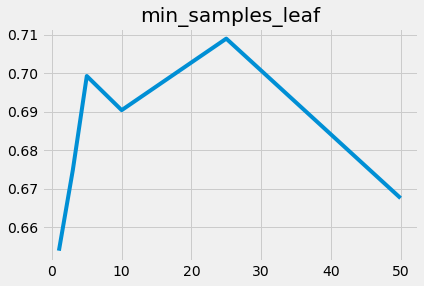

In [93]:
d={'n_estimators':100, 'n_jobs':-1}
p='min_samples_leaf'
v=[1,3,5,10,25,50]
check_parameters(p,v,d)

Fitting with max_features=log2
CPU times: user 342 ms, sys: 136 ms, total: 478 ms
Wall time: 339 ms
ROC AUC Score 0.8277582846003899
F1 0.5423728813559322
Auc 0.7161364919815005

Fitting with max_features=sqrt
CPU times: user 335 ms, sys: 126 ms, total: 461 ms
Wall time: 352 ms
ROC AUC Score 0.8164522417153997
F1 0.5423728813559322
Auc 0.6793065910470222

Fitting with max_features=0.1
CPU times: user 354 ms, sys: 113 ms, total: 467 ms
Wall time: 325 ms
ROC AUC Score 0.8154775828460039
F1 0.5517241379310345
Auc 0.7008901437008888

Fitting with max_features=0.3
CPU times: user 317 ms, sys: 163 ms, total: 479 ms
Wall time: 321 ms
ROC AUC Score 0.8273684210526315
F1 0.5546218487394958
Auc 0.6827114467928255

Fitting with max_features=0.9
CPU times: user 364 ms, sys: 157 ms, total: 521 ms
Wall time: 323 ms
ROC AUC Score 0.8127875243664717
F1 0.5423728813559322
Auc 0.6968028898975315



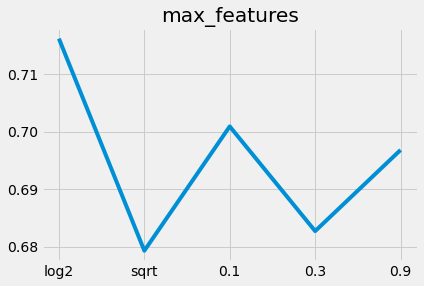

In [94]:
d={'n_estimators':100,'n_jobs':-1,'min_samples_leaf':25}
p='max_features'
v=['log2','sqrt', .1, .3, .9]
check_parameters(p,v,d)

Fitting with class_weight=balanced
CPU times: user 379 ms, sys: 116 ms, total: 495 ms
Wall time: 601 ms
ROC AUC Score 0.7942057942057942
F1 0.4878048780487805
Auc 0.5441019426533632

Fitting with class_weight=balanced_subsample
CPU times: user 474 ms, sys: 118 ms, total: 592 ms
Wall time: 705 ms
ROC AUC Score 0.791833166833167
F1 0.4915662650602409
Auc 0.5295224716658119



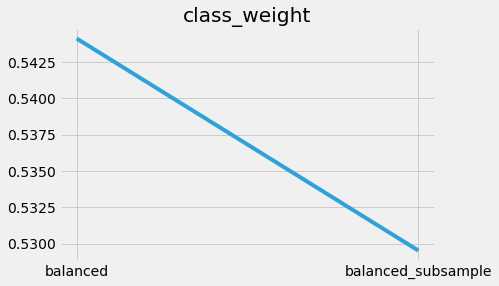

In [167]:
d={'n_estimators':100,'n_jobs':-1,'min_samples_leaf':25,'max_features': .3}
p='class_weight'
v=['balanced', 'balanced_subsample']
check_parameters(p,v,d)

In [118]:
d={'n_estimators':100,'n_jobs':-1,'min_samples_leaf':25,'max_features': .3,
   'class_weight':'balanced', 'random_state':428}

In [169]:
model=RandomForestClassifier(**d)
%time model.fit(X_train,y_train)

CPU times: user 383 ms, sys: 128 ms, total: 511 ms
Wall time: 551 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.8481028599285018
    Training F1 : 0.5941704035874439
    Training AUC: 0.6686483112665729

    Validation ROC_AUC: 0.7940434565434568
    Validation F1: 0.4889975550122249
    Validation AUC: 0.537150215141813

    
True Negatives: 403
False Positives: 169
False Negatives 40
True Positives: 100
Recall: 0.7142857142857143
Precision: 0.37174721189591076


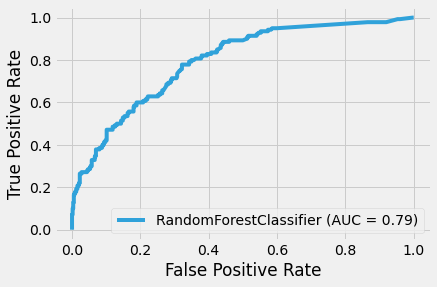

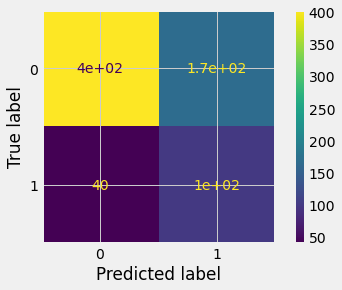

In [170]:
print_report(model,train,valid,'has_gathered_one_customer')


    Training ROC_AUC :0.8155237997327028
    Training F1 : 0.5980707395498392
    Training AUC: 0.6645451835857468

    Validation ROC_AUC: 0.8189473684210525
    Validation F1: 0.6352941176470588
    Validation AUC: 0.6845881921042078

    
True Negatives: 130
False Positives: 41
False Negatives 21
True Positives: 54
Recall: 0.72
Precision: 0.5684210526315789


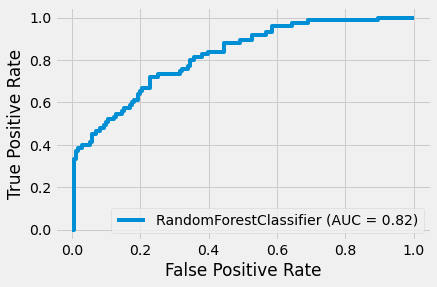

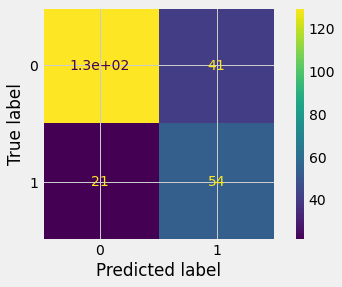

In [98]:
print_report(model,train,valid,'has_gathered_one_customer')

In [99]:
df.has_gathered_one_customer.value_counts()

0    1098
1     297
Name: has_gathered_one_customer, dtype: int64

In [100]:
train.has_gathered_one_customer.value_counts()

0    355
1    137
Name: has_gathered_one_customer, dtype: int64

In [171]:
perm=permutation_importance(model,X_train,y_train,n_repeats=5,n_jobs=-1)
perm=pd.DataFrame({'importance':perm['importances_mean']},index=X_train.columns)
perm.sort_values(by=['importance'],inplace=True)

<AxesSubplot:>

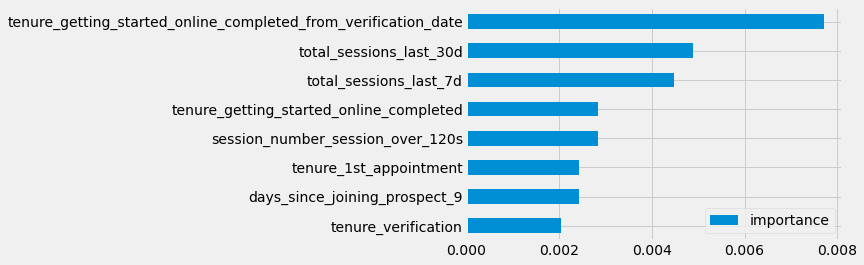

In [104]:
perm[perm.importance>0.002].plot(kind='barh')

In [41]:
perm_features=perm[perm.importance>0.002].index.tolist()
#Removing as it is a duplicate of `tenure_getting_started_online_completed`
# perm_features.remove('days_since_joining_prospect_1')
# perm_features.remove('days_since_joining_prospect_9')

In [119]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':25,'max_features': 'log2',
   'class_weight':'balanced', 'random_state':428}

In [176]:
model=RandomForestClassifier(**d)
%time model.fit(X_train[perm_features],y_train)

CPU times: user 395 ms, sys: 116 ms, total: 511 ms
Wall time: 551 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.8431372549019608
    Training F1 : 0.6027088036117382
    Training AUC: 0.6560281565587106

    Validation ROC_AUC: 0.7976523476523477
    Validation F1: 0.47880299251870323
    Validation AUC: 0.5241658732129679

    
True Negatives: 407
False Positives: 165
False Negatives 44
True Positives: 96
Recall: 0.6857142857142857
Precision: 0.367816091954023


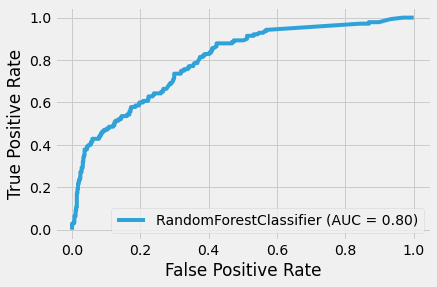

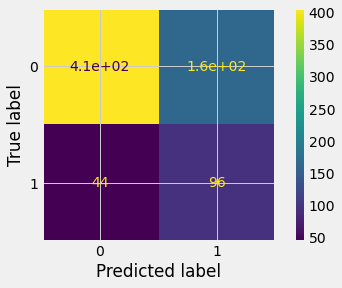

In [177]:
print_report(model,train,valid,'has_gathered_one_customer',perm_features)


    Training ROC_AUC :0.822298756039889
    Training F1 : 0.6265060240963856
    Training AUC: 0.6560929068133277

    Validation ROC_AUC: 0.80046783625731
    Validation F1: 0.593939393939394
    Validation AUC: 0.681650560412107

    
True Negatives: 130
False Positives: 41
False Negatives 26
True Positives: 49
Recall: 0.6533333333333333
Precision: 0.5444444444444444


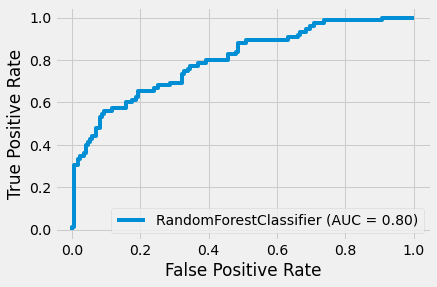

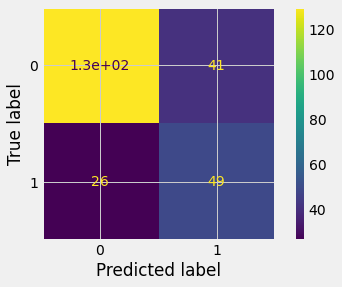

In [108]:
print_report(model,train,valid,'has_gathered_one_customer',perm_features)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


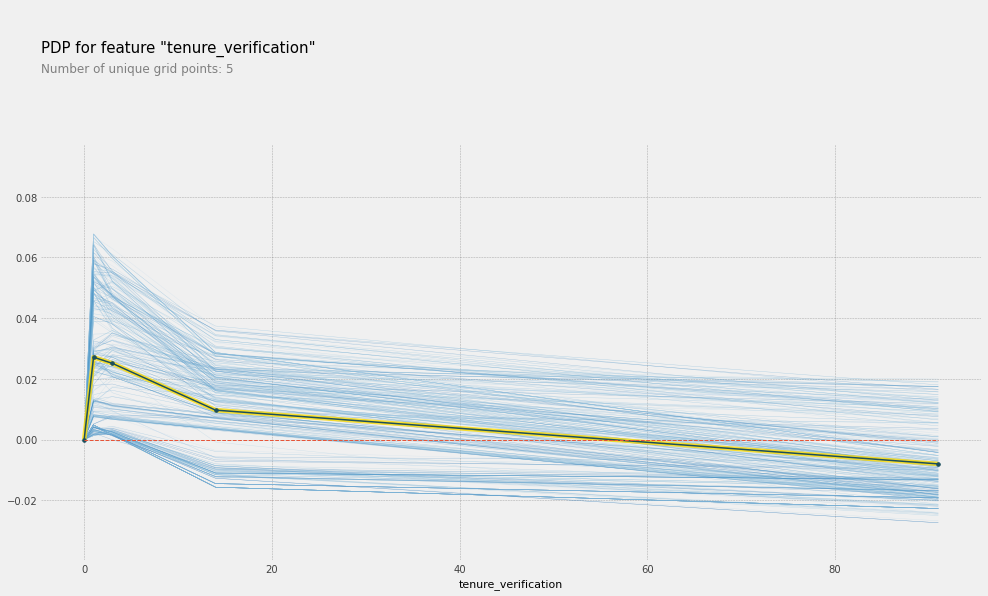

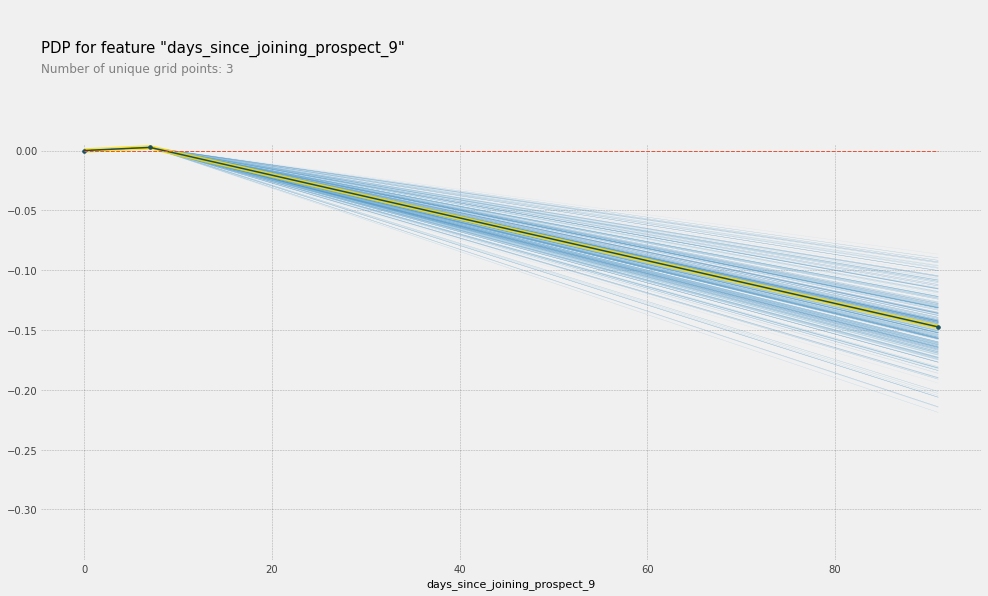

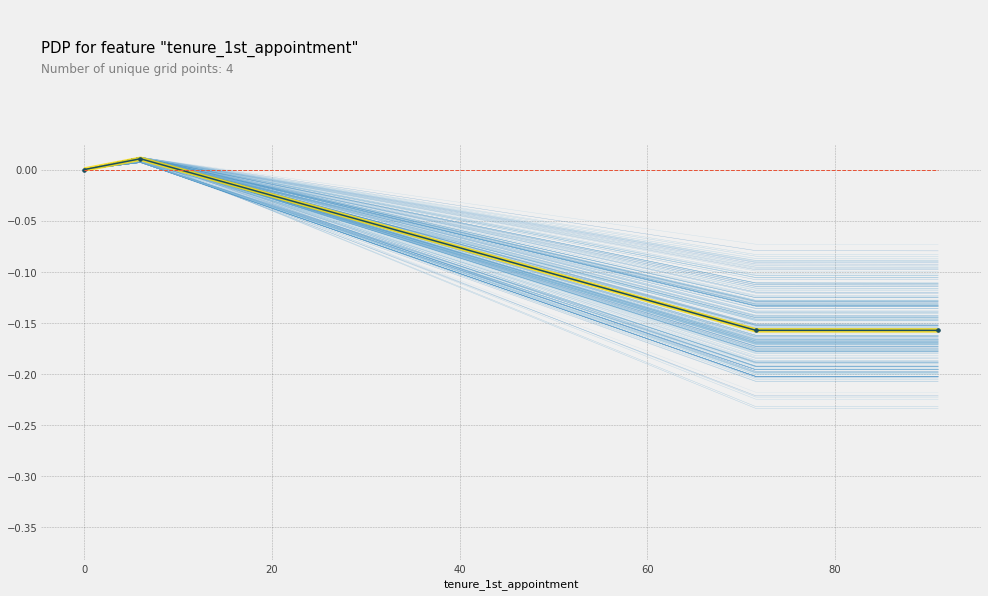

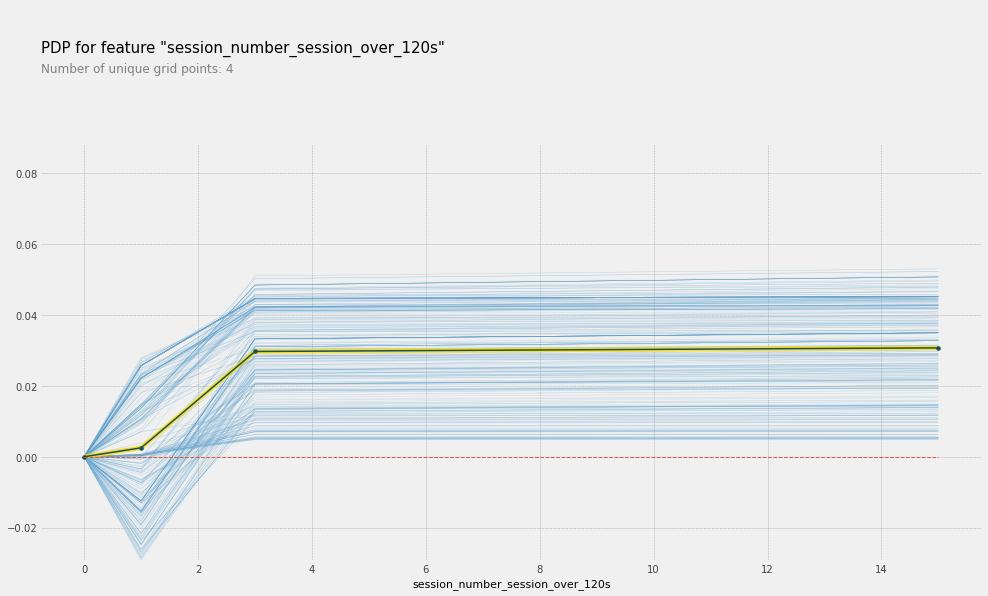

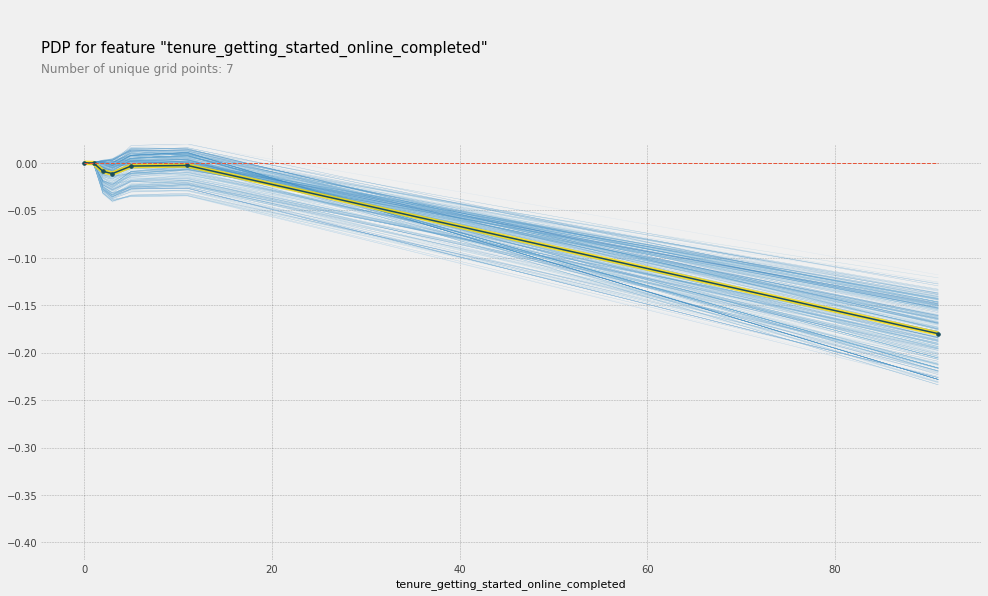

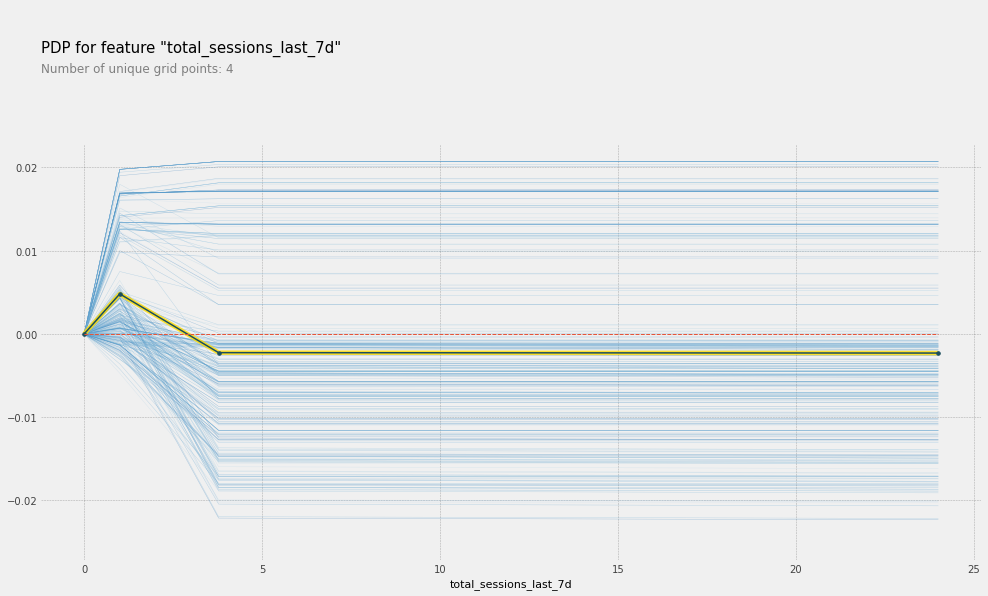

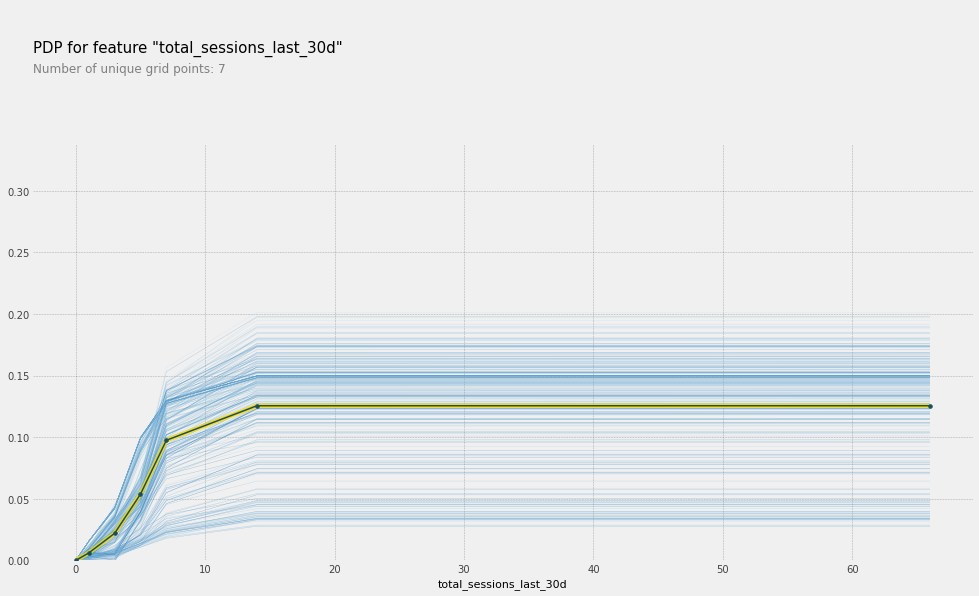

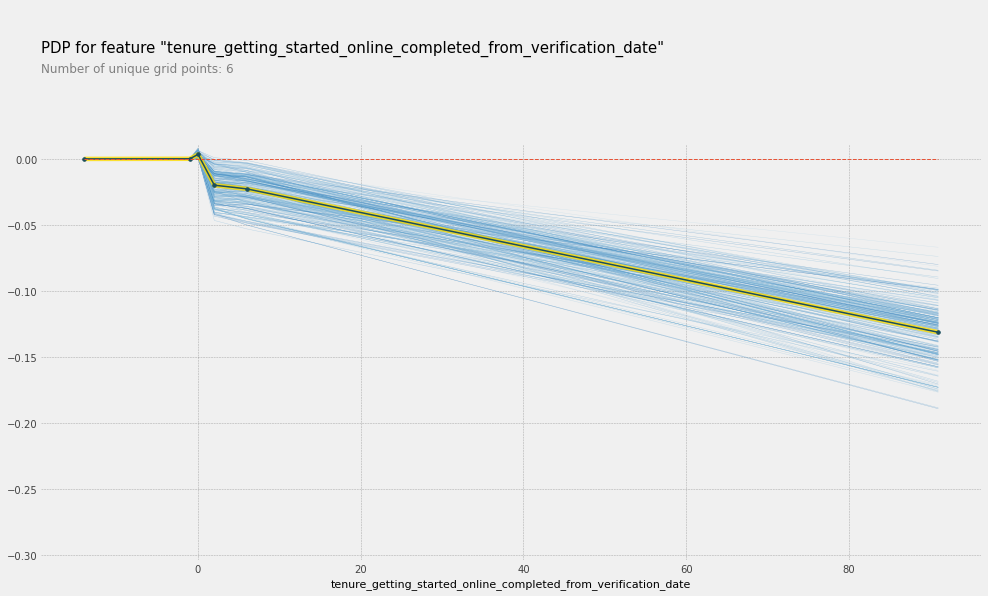

In [110]:
for f in perm_features:

    p=pdp.pdp_isolate(model,X_train.sample(300),perm_features,f)
    pdp.pdp_plot(p, f, plot_lines=True, n_cluster_centers=5)

In [111]:
perm_features=

['tenure_verification',
 'days_since_joining_prospect_9',
 'tenure_1st_appointment',
 'session_number_session_over_120s',
 'tenure_getting_started_online_completed',
 'total_sessions_last_7d',
 'total_sessions_last_30d',
 'tenure_getting_started_online_completed_from_verification_date']

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_1st_appointment'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


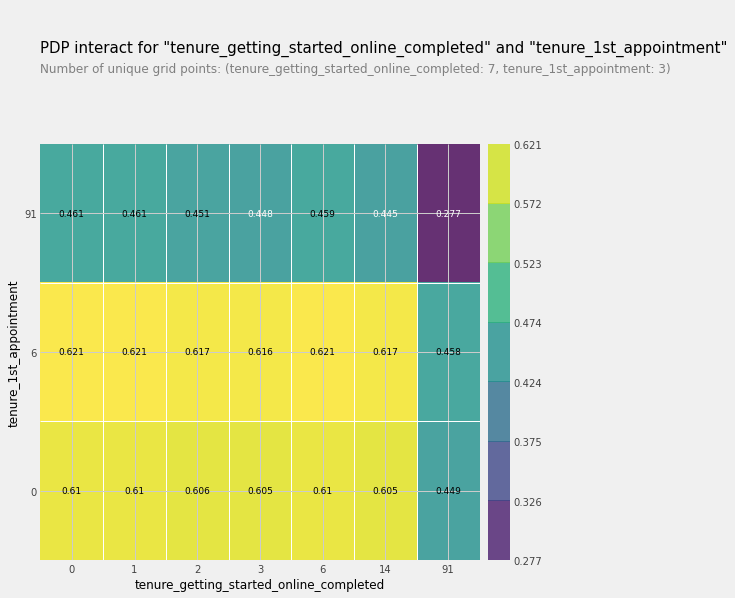

In [113]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],x_quantile=True,ncols=2,plot_type='grid')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_getting_started_online_completed_from_verification_date'>})

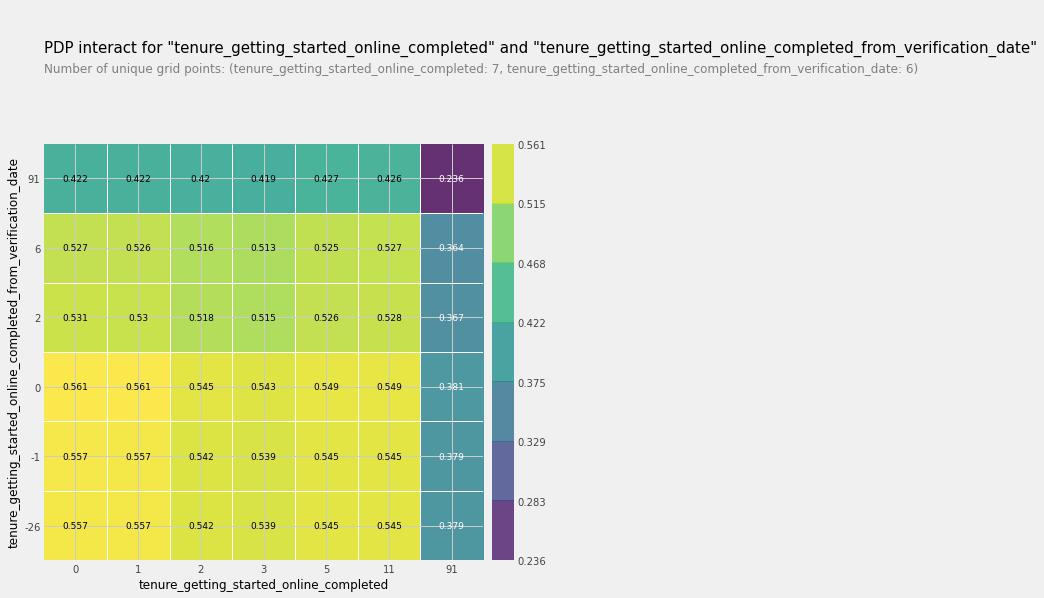

In [114]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],x_quantile=True,ncols=2,plot_type='grid')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_getting_started_online_completed_from_verification_date'>})

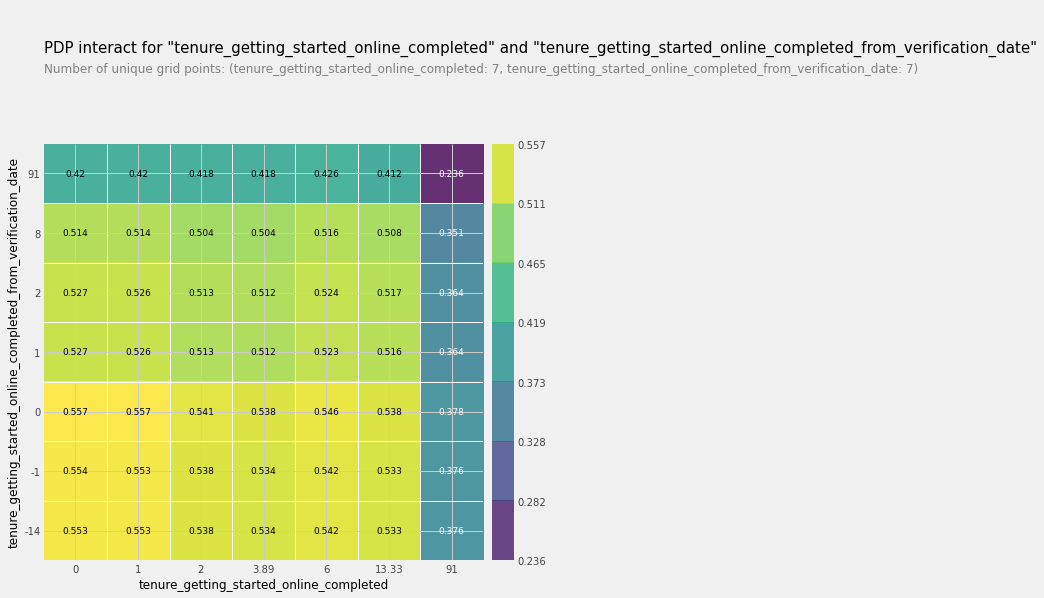

In [117]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],x_quantile=True,ncols=2,plot_type='grid')

In [118]:
shap_values=shap.TreeExplainer(model).shap_values(X_train)

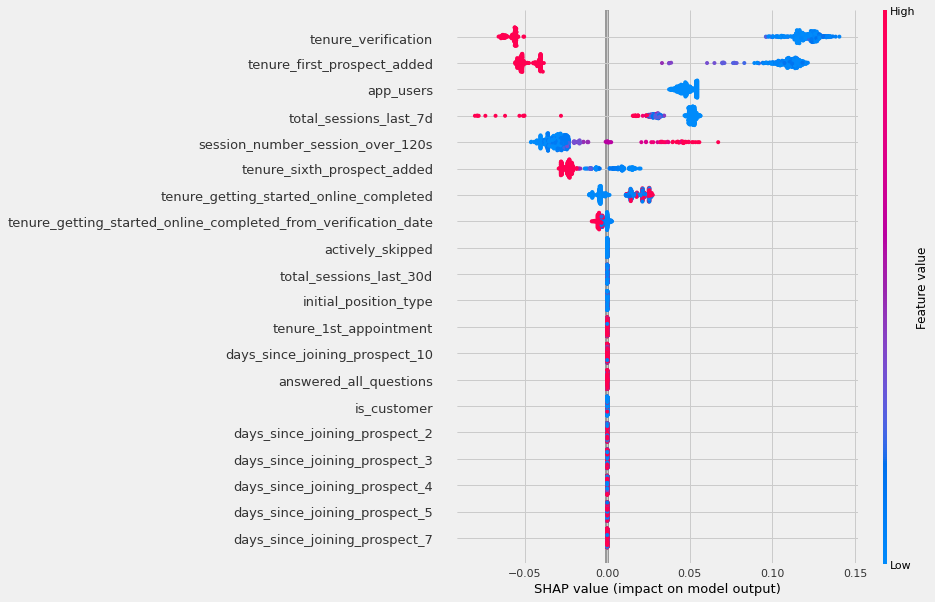

In [122]:
shap.summary_plot(shap_values[1],X_train)

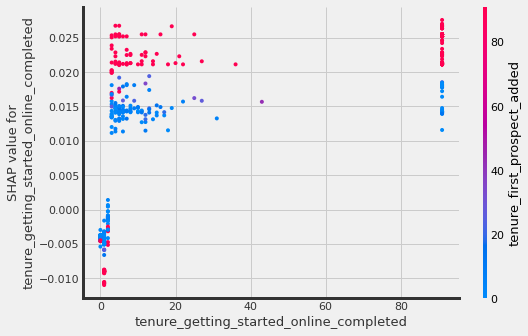

In [123]:
shap.dependence_plot('tenure_getting_started_online_completed',shap_values[1],X_train)

In [111]:
shap.initjs()

In [120]:
X_output= X_valid[perm_features].copy()
y_pred=model.predict(X_valid[perm_features])
X_output.loc[:,'predict']=np.round(y_pred,2)

In [156]:
def shap_plot(j):
    explainerModel=shap.TreeExplainer(model)
    shap_values_model=explainerModel.shap_values(X_output)
    p=shap.force_plot(explainerModel.expected_value[0],
                    shap_values_model[0][j],X_output.iloc[[j]])
    return(p)

In [158]:
shap_plot(100)

### Save Model

In [48]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':5,'max_features': .1,
   'class_weight':'balanced', 'random_state':428}
perm_features=[
    'answered_all_questions',
 'app_users',
 'days_since_joining_prospect_3',
 'tenure_verification',
 'total_sessions_last_30d',
 'days_since_joining_prospect_2',
 'is_customer',
 'tenure_1st_appointment',
 'tenure_getting_started_online_completed',
 'tenure_first_prospect_added',
 'tenure_getting_started_online_completed_from_verification_date']

In [49]:
model=RandomForestClassifier(**d)
%time model.fit(X_train[perm_features],y_train)

CPU times: user 4.06 s, sys: 1.54 s, total: 5.6 s
Wall time: 7.05 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.8941301656090388
    Training F1 : 0.6637426900584795
    Training AUC: 0.7707585081281729

    Validation ROC_AUC: 0.8193790149892933
    Validation F1: 0.5867507886435331
    Validation AUC: 0.5387917253090317

    
True Negatives: 373
False Positives: 94
False Negatives 37
True Positives: 93
Recall: 0.7153846153846154
Precision: 0.49732620320855614


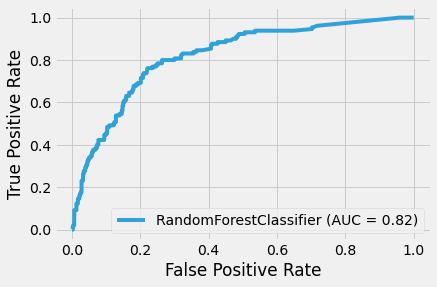

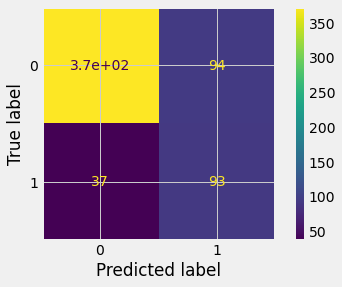

In [50]:
print_report(model,train,valid,'has_gathered_one_customer',perm_features)

In [51]:
suffix=str(datetime.now().strftime('%Y-%m-%d'))

In [52]:
model_name='_'.join(['model_rf_one_customer',suffix,'.pkl'])

In [53]:
with open (os.path.join(os.getcwd(),model_name),'wb') as f:
    joblib.dump(model,f)

In [56]:
model=joblib.load([c for c in os.listdir() if 'model_rf_one_customer' in c][0])

In [57]:
import random
import itertools

In [90]:
prosps=[]
for fp in range(3,11):
    for sp in range(fp,16):
        tp=random.choice([*range(sp,16)]+[91])
        prosps.append([fp,sp,tp])

In [92]:
def print_comba_dict(*args):
    isc,ans,gs,tv,fsapp,ps=args
    d={  'tenure_verification': tv, #Between 1 and 16 days since joining
                            'tenure_first_prospect_added': ps[0], #Between 1 and 16 days since joining
                            'days_since_joining_prospect_2': ps[1],
                            'days_since_joining_prospect_3': ps[2],
                            'tenure_1st_appointment': fsapp,
                            'tenure_getting_started_online_completed': gs,
                            'tenure_getting_started_online_completed_from_verification_date': gs - tv,
                            'total_sessions_last_30d': random.choice([*range(5, 16)]),
                            'is_customer': isc,
                            'answered_all_questions': ans,
                            'app_users': True}
    return d

In [103]:
synthetic_df=pd.DataFrame([print_comba_dict(*i) for i in itertools.product((True,False),
              (True,False),
            (1, 2, 3, 4, 5, 6),
             (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
             (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
               prosps)])

In [111]:
features = [
    
    'answered_all_questions',
 'app_users',
 'days_since_joining_prospect_3',
 'tenure_verification',
 'total_sessions_last_30d',
 'days_since_joining_prospect_2',
 'is_customer',
 'tenure_1st_appointment',
 'tenure_getting_started_online_completed',
 'tenure_first_prospect_added',
 'tenure_getting_started_online_completed_from_verification_date']

In [115]:
synthetic_df=synthetic_df.loc[:,features]

In [124]:
synthetic_df['predictions']=model.predict_proba(synthetic_df)[:,1]

In [125]:
synthetic_df.shape

(410400, 12)

In [126]:

onbj = ['tenure_first_prospect_added',
    'days_since_joining_prospect_2',
 'days_since_joining_prospect_3',
 'tenure_verification',
 'tenure_getting_started_online_completed',
 'tenure_1st_appointment',
 'tenure_getting_started_online_completed_from_verification_date']

In [127]:
top_journey=np.quantile(synthetic_df.predictions,0.99)

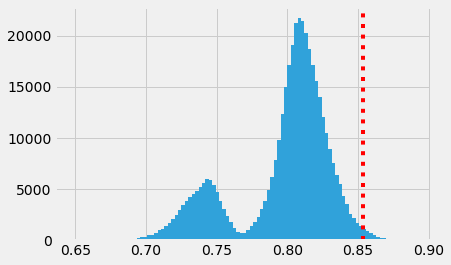

In [129]:
synthetic_df.predictions.hist(bins=100)
plt.axvline(top_journey,c='red',linestyle=':')

In [131]:
cohort=synthetic_df.predictions>top_journey

In [133]:
synthetic_df.loc[cohort].sort_values('predictions').loc[:,onbj+['predictions']]

,tenure_first_prospect_added,days_since_joining_prospect_2,days_since_joining_prospect_3,tenure_verification,tenure_getting_started_online_completed,tenure_1st_appointment,tenure_getting_started_online_completed_from_verification_date,predictions
335542,3,5,9,10,2,6,-8,0.853567
234690,3,5,9,11,2,14,-9,0.853568
288208,4,7,12,13,5,13,-8,0.853569
47048,3,7,8,12,3,5,-9,0.853575
291499,6,9,11,1,6,11,5,0.853576
...,...,...,...,...,...,...,...,...
274310,5,6,11,1,5,10,4,0.885744
269345,3,4,5,12,4,5,-8,0.886185
274236,5,8,13,1,5,9,4,0.886716
274082,5,6,11,1,5,7,4,0.886790


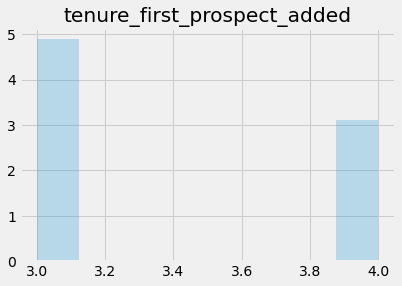

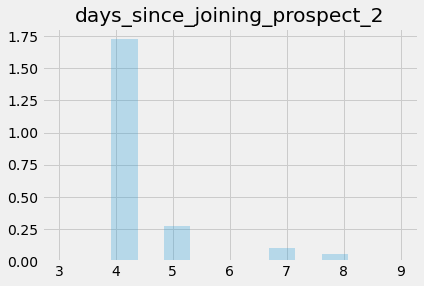

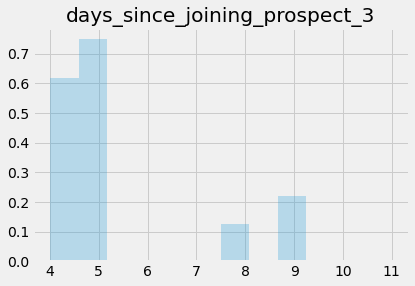

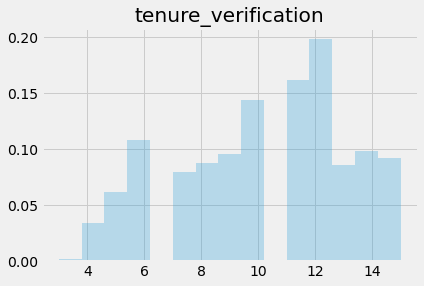

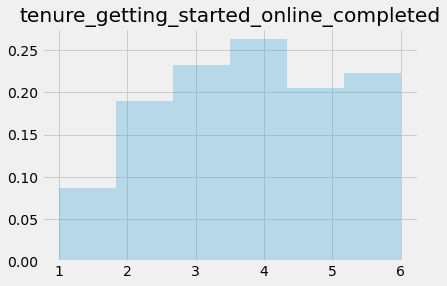

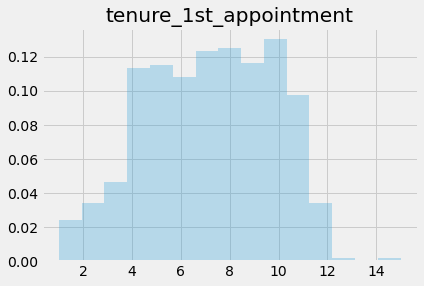

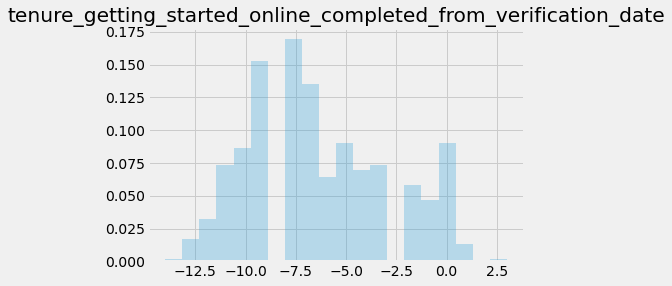

In [145]:
for f in onbj:
    fig,ax=plt.subplots()
    ax.set_title(f)
    bins=synthetic_df.loc[synthetic_df[f] < 91, f].max() - synthetic_df[f].min() + 1   
    (synthetic_df
     .loc[cohort, f]
     .hist(ax=ax, density=True, alpha=.3, bins=bins))

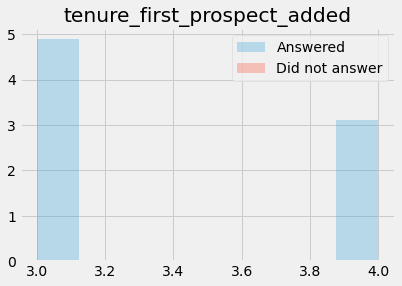

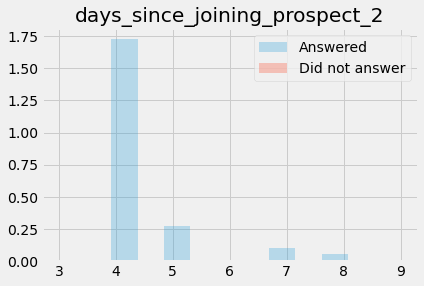

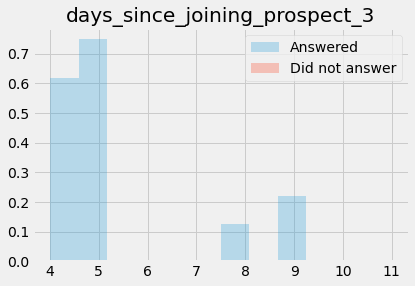

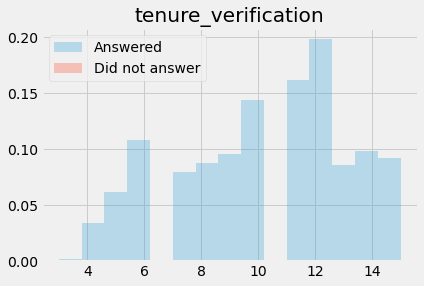

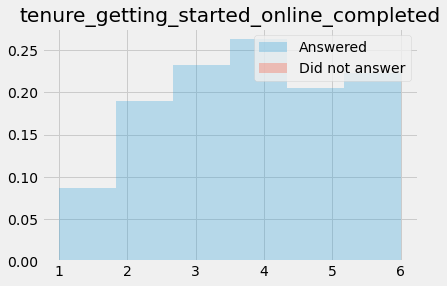

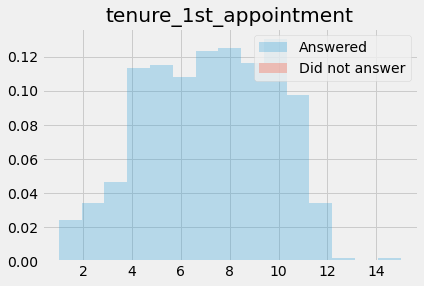

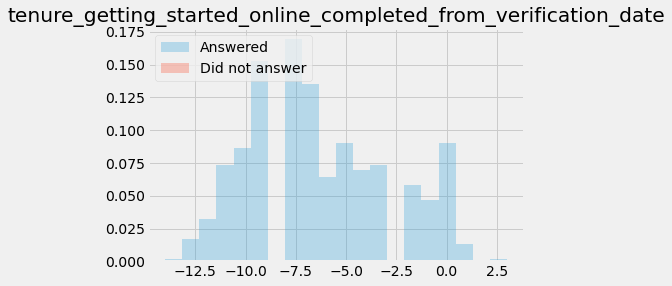

In [143]:

cohort = (synthetic_df.is_customer)  & (synthetic_df.predictions > top_journey)
synthetic_df.loc[cohort].sort_values('predictions').loc[:, onbj + ['predictions']]

for f in onbj:
    fig, ax = plt.subplots()
    ax.set_title(f)
    bins=synthetic_df.loc[synthetic_df[f] < 91, f].max() - synthetic_df[f].min() + 1
    (synthetic_df
     .loc[cohort & (synthetic_df.answered_all_questions), f]
     .hist(ax=ax, density=True, alpha=.3, bins=bins, label='Answered', stacked=False))
    (synthetic_df
     .loc[cohort & (~synthetic_df.answered_all_questions), f]
     .hist(ax=ax, density=True, alpha=.3, bins=bins, label='Did not answer', stacked=True))
    ax.legend()

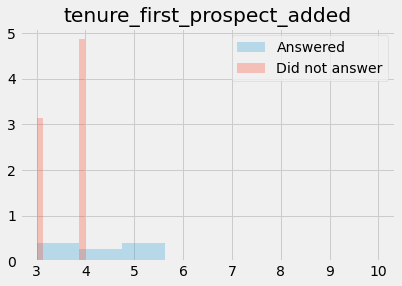

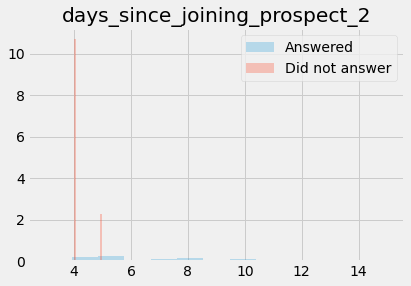

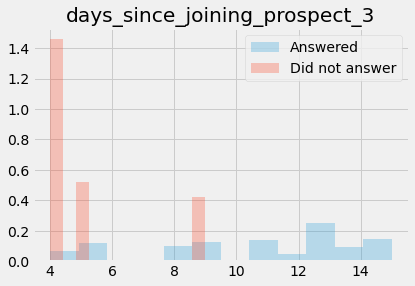

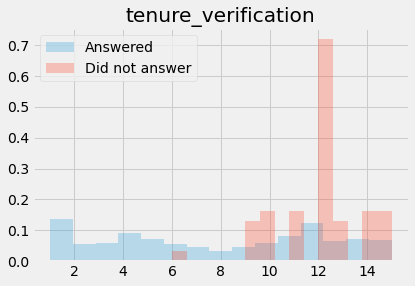

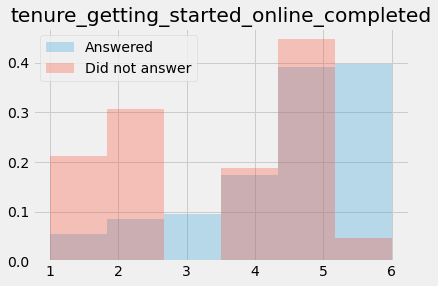

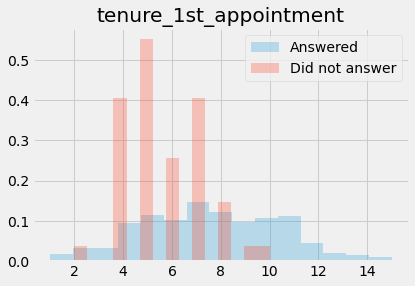

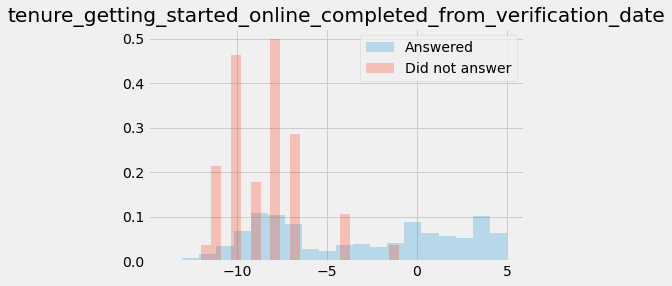

In [146]:
cohort = (~synthetic_df.is_customer)  & (synthetic_df.predictions > top_journey)
synthetic_df.loc[cohort].sort_values('predictions').loc[:, onbj + ['predictions']]

for f in onbj:
    fig, ax = plt.subplots()
    ax.set_title(f)
    bins=synthetic_df.loc[synthetic_df[f] < 91, f].max() - synthetic_df[f].min() + 1
    (synthetic_df
     .loc[cohort & (synthetic_df.answered_all_questions), f]
     .hist(ax=ax, density=True, alpha=.3, bins=bins, label='Answered', stacked=False))
    (synthetic_df
     .loc[cohort & (~synthetic_df.answered_all_questions), f]
     .hist(ax=ax, density=True, alpha=.3, bins=bins, label='Did not answer', stacked=True))
    ax.legend()

## LightGBM

In [284]:
train,valid=split_df(model_df_copy,ldf - len_to_take,len_to_take)
X_train,y_train,X_valid,y_valid=split_x_y(train,valid,'has_gathered_one_customer')

In [285]:
from copy import copy
from time import time
from typing import Union
from lightgbm import Dataset as lgbDataset
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score

In [286]:
cat_cols=[]
target='has_gathered_one_customer'
for col in train.columns:
    if train[col].dtype=='O' or train[col].nunique()<15 and col!=target:
        cat_cols.append(col)
num_cols = [c for c in train.columns if c not in cat_cols +[target]]

In [287]:
# for col in cat_cols:
#     le=LabelEncoder()
#     train[col]=le.fit_transform(train[col])
#     le_dict=dict(zip(le.classes_,le.transform(le.classes_)))
#     valid[col]=le.transform(valid[col])

In [288]:
lgbtrain=lgbDataset(
    train[cat_cols+num_cols],train[target],
    categorical_feature=cat_cols,free_raw_data=False)
lgbvalid=lgbDataset(valid[cat_cols+num_cols],
           valid[target],reference=lgbtrain,free_raw_data=False)

In [289]:
OPTIMIZE_WITH = "optuna"

In [290]:
if OPTIMIZE_WITH =='optuna':
    optimizer: Union[LGBOptimizerHyperopt, LGBOptimizerOptuna]=LGBOptimizerOptuna()
elif OPTIMIZE_WITH =='hyperopt':
    optimizer = LGBOptimizerHyperopt(verbose=True,objective='binary')

In [291]:
optimizer.optimize(lgbtrain,lgbvalid)

[I 2021-06-23 12:29:45,305] A new study created in memory with name: no-name-6041fffc-5cac-4672-9fc3-2ca6e7e3941e
min_data_in_leaf, val_score: 0.363940: 100%|##########| 5/5 [00:09<00:00,  1.90s/it]


In [292]:
optimizer.best

{'objective': 'binary',
 'verbosity': -1,
 'is_unbalance': False,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 4,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'n_estimators': 1000}

In [293]:
params=copy(optimizer.best)

In [294]:
params['is_unbalance']=True

In [295]:
start=time()

In [296]:
model=lgb.train(params,lgbtrain,valid_sets=[lgbvalid],
          early_stopping_rounds=50,verbose_eval=True)
runtime=time()-start

[1]	valid_0's binary_logloss: 0.487843
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.474538
[3]	valid_0's binary_logloss: 0.464669
[4]	valid_0's binary_logloss: 0.458778
[5]	valid_0's binary_logloss: 0.457793
[6]	valid_0's binary_logloss: 0.456105
[7]	valid_0's binary_logloss: 0.456541
[8]	valid_0's binary_logloss: 0.456602
[9]	valid_0's binary_logloss: 0.455054
[10]	valid_0's binary_logloss: 0.455762
[11]	valid_0's binary_logloss: 0.4561
[12]	valid_0's binary_logloss: 0.458593
[13]	valid_0's binary_logloss: 0.461074
[14]	valid_0's binary_logloss: 0.462848
[15]	valid_0's binary_logloss: 0.463956
[16]	valid_0's binary_logloss: 0.465588
[17]	valid_0's binary_logloss: 0.466876
[18]	valid_0's binary_logloss: 0.47016
[19]	valid_0's binary_logloss: 0.471406
[20]	valid_0's binary_logloss: 0.47172
[21]	valid_0's binary_logloss: 0.472649
[22]	valid_0's binary_logloss: 0.473442
[23]	valid_0's binary_logloss: 0.474515
[24]	valid_0's binary_logloss: 0

In [297]:
preds=(model.predict(lgbvalid.data)>0.5).astype('int')

In [298]:
acc=accuracy_score(lgbvalid.label,preds)
auc=roc_auc_score(lgbvalid.label,preds)
f1=f1_score(lgbvalid.label,preds)

Accuracy: 0.8132780082987552. F1: 0.5. ROC_AUC: 0.6802753382387847
Recall: 0.45454545454545453
Precision: 0.5555555555555556
[[347  36]
 [ 54  45]]


Text(13.060000000000002, 0.5, 'True label')

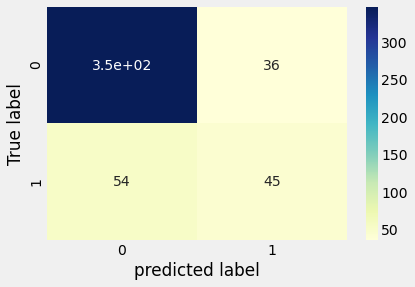

In [299]:
tn,fp,fn,tp=confusion_matrix(lgbvalid.label,preds).ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'Accuracy: {acc}. F1: {f1}. ROC_AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(confusion_matrix(lgbvalid.label,preds))
cm=confusion_matrix(lgbvalid.label,preds)

sns.heatmap(cm,annot=True,cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('True label')

In [231]:
def check_lgb_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts= lgbtrain.data.columns if features is None else features
        kw = {parameters:p, **fixed}
        model=lgb.LGBMClassifier(**kw)
        model.fit(lgbtrain.data[fts],lgbtrain.label)
        s=roc_auc_score(lgbvalid.label,model.predict_proba(lgbvalid.data)[:,1])
        rf_f1,rf_auc=auc_score(model,lgbvalid.data[fts],lgbvalid.label)
        
        print('ROC AUC Score',s)
        print('F1',rf_f1)
        print('Auc',rf_auc)
        print('')
        scores.append(rf_auc)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)

Fitting with learning_rate=0.01
ROC AUC Score 0.8107793622499504
F1 0.3211678832116788
Auc 0.5444328782529536

Fitting with learning_rate=0.3
ROC AUC Score 0.6888987918399684
F1 0.44329896907216493
Auc 0.4850430375005009



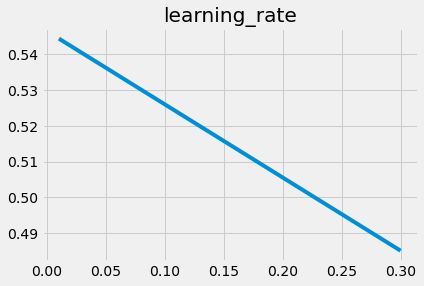

In [233]:
check_lgb_parameters(p,v)

Fitting with n_estimators=10
ROC AUC Score 0.7981654783125371
F1 0.0
Auc 0.5090516779036963

Fitting with n_estimators=30
ROC AUC Score 0.8024485046543869
F1 0.0
Auc 0.5309360219146206

Fitting with n_estimators=50
ROC AUC Score 0.804998514557338
F1 0.0
Auc 0.5320681263625244

Fitting with n_estimators=100
ROC AUC Score 0.8107793622499504
F1 0.3211678832116788
Auc 0.5444328782529536

Fitting with n_estimators=200
ROC AUC Score 0.804948999801941
F1 0.45283018867924524
Auc 0.5573801461294104

Fitting with n_estimators=300
ROC AUC Score 0.7987720340661517
F1 0.4615384615384615
Auc 0.5463507471303988



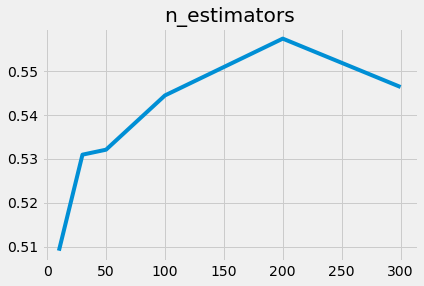

In [236]:
f={'learning_rate':0.01}
p='n_estimators'
v=[10,30,50,100,200,300]
check_lgb_parameters(p,v,f)

Fitting with num_leaves=10
ROC AUC Score 0.8091082392552981
F1 0.4578313253012048
Auc 0.5476431146090984

Fitting with num_leaves=20
ROC AUC Score 0.8037977817389583
F1 0.46625766871165647
Auc 0.5439324643071901

Fitting with num_leaves=50
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301

Fitting with num_leaves=100
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301



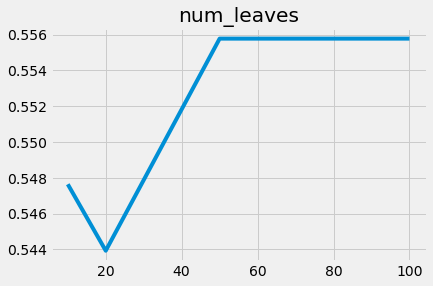

In [237]:
f={'learning_rate':0.01,
  'n_estimators':200}
p='num_leaves'
v=[10,20,50,100]
check_lgb_parameters(p,v,f)

Fitting with min_child_samples=10
ROC AUC Score 0.7730367399485047
F1 0.39751552795031053
Auc 0.505391380424229

Fitting with min_child_samples=20
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301

Fitting with min_child_samples=30
ROC AUC Score 0.8094548425430779
F1 0.47204968944099374
Auc 0.5758549836926047

Fitting with min_child_samples=50
ROC AUC Score 0.8121905327787681
F1 0.47500000000000003
Auc 0.597226429942811

Fitting with min_child_samples=100
ROC AUC Score 0.8144805902158844
F1 0.4578313253012048
Auc 0.5839939173592095



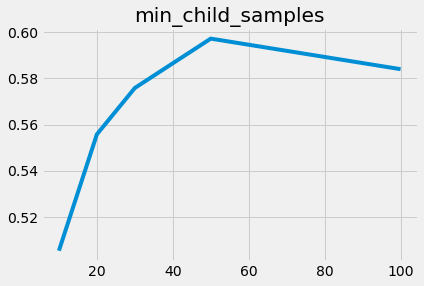

In [240]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50}
p='min_child_samples'
v=[10,20,30,50,100]
check_lgb_parameters(p,v,f)

Fitting with colsample_bytree=0.5
ROC AUC Score 0.8246311150722915
F1 0.46249999999999997
Auc 0.6124129306184783

Fitting with colsample_bytree=1.0
ROC AUC Score 0.8121905327787681
F1 0.47500000000000003
Auc 0.597226429942811



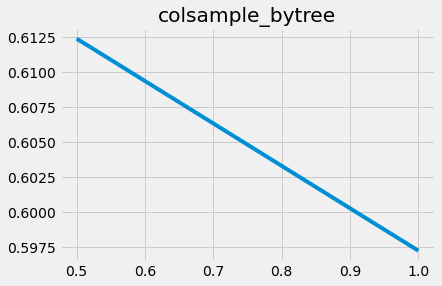

In [241]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50}
p='colsample_bytree'
v=[0.5, 1.0]
check_lgb_parameters(p,v,f)

Fitting with reg_alpha=0.01
ROC AUC Score 0.823715092097445
F1 0.46249999999999997
Auc 0.6085724343836147

Fitting with reg_alpha=0.05
ROC AUC Score 0.8238636363636362
F1 0.46249999999999997
Auc 0.612293791262041

Fitting with reg_alpha=0.1
ROC AUC Score 0.8226257674787085
F1 0.46249999999999997
Auc 0.6106740009238906

Fitting with reg_alpha=0.2
ROC AUC Score 0.8226505248564072
F1 0.46249999999999997
Auc 0.6136264862246186

Fitting with reg_alpha=0.4
ROC AUC Score 0.820409982174688
F1 0.4556962025316456
Auc 0.6144118453510514

Fitting with reg_alpha=1.0
ROC AUC Score 0.8198158051099227
F1 0.4430379746835442
Auc 0.6113084770502017

Fitting with reg_alpha=2.0
ROC AUC Score 0.820806100217865
F1 0.45859872611464964
Auc 0.6087057845009681



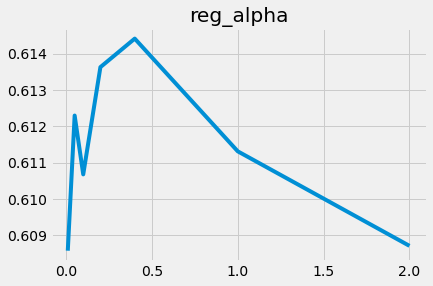

In [243]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5}
p='reg_alpha'
v=[0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0]
check_lgb_parameters(p,v,f)

Fitting with reg_lambda=0.01
ROC AUC Score 0.8228485838779956
F1 0.46249999999999997
Auc 0.6136743025028566

Fitting with reg_lambda=0.05
ROC AUC Score 0.8211155674390967
F1 0.46249999999999997
Auc 0.6132561552130436

Fitting with reg_lambda=0.1
ROC AUC Score 0.8204471182412358
F1 0.4556962025316456
Auc 0.6151168028210755

Fitting with reg_lambda=0.2
ROC AUC Score 0.8210908100613983
F1 0.4556962025316456
Auc 0.6170753646070349

Fitting with reg_lambda=0.4
ROC AUC Score 0.8197415329768271
F1 0.4556962025316456
Auc 0.6142466107720632

Fitting with reg_lambda=1.0
ROC AUC Score 0.8198158051099227
F1 0.445859872611465
Auc 0.6127082541330753

Fitting with reg_lambda=2.0
ROC AUC Score 0.8197539116656763
F1 0.4487179487179487
Auc 0.6076995234303983



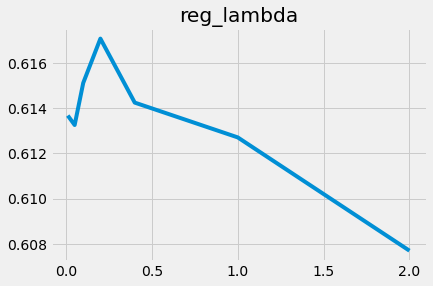

In [244]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2}
p='reg_lambda'
v=[0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0]
check_lgb_parameters(p,v,f)

Fitting with boosting_type=gbdt
ROC AUC Score 0.8356406519861831
F1 0.43356643356643354
Auc 0.5790900120363615

Fitting with boosting_type=dart
ROC AUC Score 0.8325102547495682
F1 0.43283582089552236
Auc 0.5934289075122707

Fitting with boosting_type=goss
ROC AUC Score 0.8323078583765112
F1 0.45517241379310336
Auc 0.5789625817050246



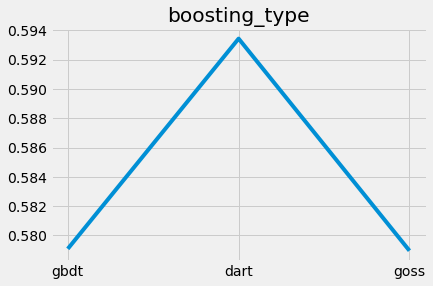

In [260]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2}
p='boosting_type'
v=['gbdt','dart','goss']
check_lgb_parameters(p,v,f)

Fitting with max_depth=2
ROC AUC Score 0.8271669905008636
F1 0.39999999999999997
Auc 0.5744114424848239

Fitting with max_depth=3
ROC AUC Score 0.8300680051813472
F1 0.42424242424242425
Auc 0.5811676071043023

Fitting with max_depth=5
ROC AUC Score 0.8323618307426598
F1 0.43283582089552236
Auc 0.5932161650333208

Fitting with max_depth=10
ROC AUC Score 0.8325102547495682
F1 0.43283582089552236
Auc 0.5934289075122707



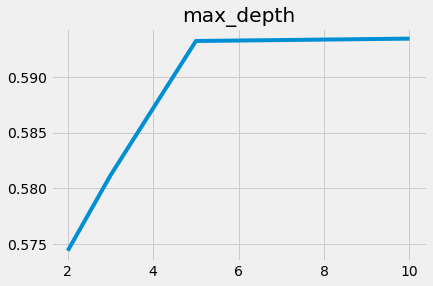

In [261]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2,
  'boosting_type':'dart'}
p='max_depth'
v=[2,3,5,10]
check_lgb_parameters(p,v,f)

In [269]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2,
  'boosting_type':'gbdt',
  'max_depth':5,
  'objective':'binary',
  'random_state':482}

In [270]:
model=lgb.LGBMClassifier(**f)
%time model.fit(lgbtrain.data,lgbtrain.label)

CPU times: user 13.7 s, sys: 210 ms, total: 13.9 s
Wall time: 2.99 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=50, objective='binary',
               random_state=482, reg_alpha=0.2, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


    Training ROC_AUC :0.856170542635659
    Training F1 : 0.5047318611987381
    Training AUC: 0.6929473472310486

    Validation ROC_AUC: 0.82628993955095
    Validation F1: 0.43971631205673756
    Validation AUC: 0.5782971490183102

    
True Negatives: 372
False Positives: 14
False Negatives 65
True Positives: 31
Recall: 0.3229166666666667
Precision: 0.6888888888888889


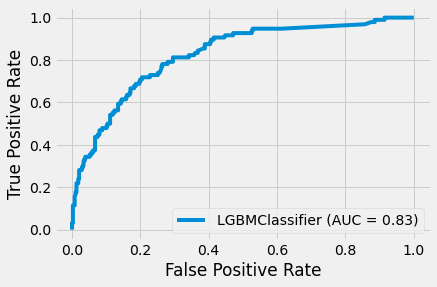

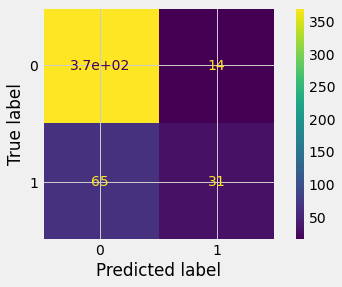

In [272]:
print_lgb_report(model,lgbtrain,lgbvalid)

In [319]:
# SAVE RESULTS

from datetime import datetime
suffix=str(datetime.now()).replace(' ','_').split('_')[:-1][0]
results_filename='_'.join(['new_partners_prection_one_customer',suffix])
model_filename='_'.join(['model_new_partners_prection_one_customer',suffix])

In [328]:
with open(os.path.join(os.getcwd(),results_filename),'wb') as f:
    pickle.dump(results_d,f)
with open(os.path.join(os.getcwd(),model_filename),'wb') as f:
    pickle.dump(model,f)

<_io.BufferedWriter name='/home/jovyan/persisted/RFM/new_partners_prection_one_customer_2021-06-23'>


## FACEBOOK Prophet -- Gathering One Customers Timeline

In [39]:
train,valid=split_df(model_df_copy,ldf - len_to_take,len_to_take)
X_train,y_train,X_valid,y_valid=split_x_y(train,valid,'has_gathered_one_customer')

In [166]:
df.has_gathered_six_customers.sum()/df.shape[0]

0.05238500851788756

In [167]:
df.has_gathered_six_customers.sum()

369

Mean days to gather six customers: 38.8319783197832
Median days to gather six customers: 32.0


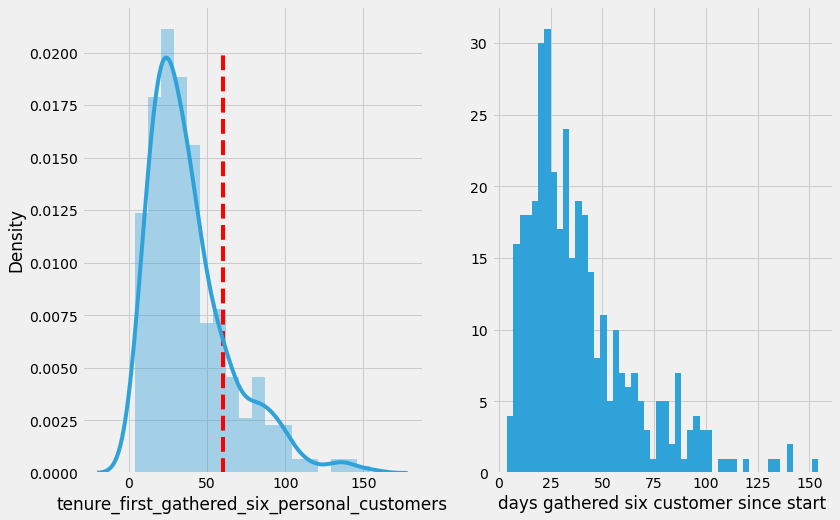

In [251]:
print('Mean days to gather six customers:', df.tenure_first_gathered_six_personal_customers.mean())
print('Median days to gather six customers:',df.tenure_first_gathered_six_personal_customers.median() )
f,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,8))
sns.distplot(df.tenure_first_gathered_six_personal_customers,ax=ax1)
plt.xlabel('days gathered six customer since start')
df.tenure_first_gathered_six_personal_customers.hist(bins=50,ax=ax2)
ax1.vlines(x=60,ymin=0,ymax=0.02,color='r',linestyles='--')

In [170]:
from lifelines import KaplanMeierFitter

In [238]:
six_cus_df=df[['started_at','first_gathered_six_personal_customers_date','has_gathered_six_customers']]

In [239]:
today=pd.to_datetime('2021-06-24')
six_cus_df.first_gathered_six_personal_customers_date.fillna(today,inplace=True)
for c in ['started_at','first_gathered_six_personal_customers_date']:
    six_cus_df[c]=pd.to_datetime(six_cus_df[c])
six_cus_df['tenure_gathered_six_customers']=(six_cus_df.first_gathered_six_personal_customers_date-six_cus_df.started_at).dt.days

In [243]:
kmf=KaplanMeierFitter()

In [246]:
kmf.fit(six_cus_df.tenure_gathered_six_customers,six_cus_df.has_gathered_six_customers,label='tenure_gathered_six_customers'.replace('_',' '))

<lifelines.KaplanMeierFitter:"tenure gathered six customers", fitted with 7044 total observations, 6675 right-censored observations>

<AxesSubplot:xlabel='timeline'>

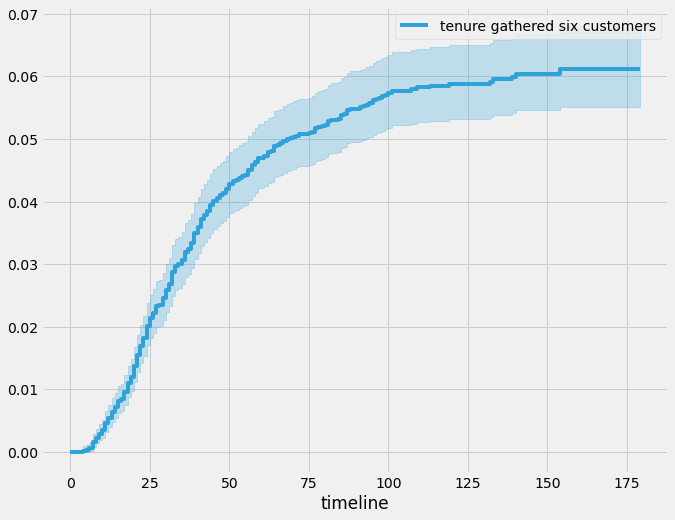

In [247]:
kmf.plot_cumulative_density(figsize=(10,8))

In [ ]:
!pip3 install pystan==2.19.1.1 --quiet
!pip3 install prophet --quiet

In [332]:
from prophet import Prophet

In [340]:
pre=Preprocessing(df[['started_at','tenure_first_gathered_six_personal_customers']].fillna(int(91)))

In [341]:
pre.check_null()

False

In [356]:
prophet_df=df[['started_at','tenure_first_gathered_six_personal_customers']].fillna(int(91))
prophet_df['started_at']=pd.to_datetime(prophet_df.started_at).dt.date
prophet_df.rename(columns={'started_at':'ds',
                           'tenure_first_gathered_six_personal_customers':'y'},inplace=True)
m=Prophet()
prophet_df.rename(columns={'started_at':'ds',
                           'tenure_first_gathered_six_personal_customers':'y'},inplace=True)

In [361]:
m.fit(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean days to gather six customers: 90.11886662059433
Median days to gather six customers: 91.0


Text(0.5, 0, 'days gathered six customer since start')

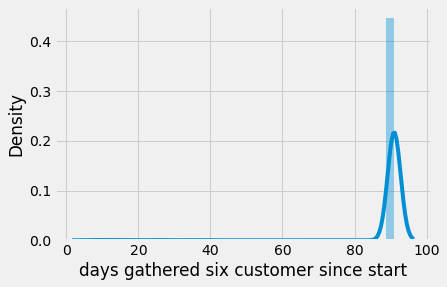

In [375]:
print('Mean days to gather six customers:', prophet_df.y.mean())
print('Median days to gather six customers:',prophet_df.y.median() )
sns.distplot(prophet_df.y)
plt.xlabel('days gathered six customer since start')

#### prophert_df with y ='first_customer_gathered'

In [431]:
prophet_df=df[['started_at','tenure_first_customer_gathered_excluding_self']].fillna(int(91))
prophet_df['started_at']=pd.to_datetime(prophet_df.started_at).dt.date
prophet_df.rename(columns={'started_at':'ds',
                           'tenure_first_customer_gathered_excluding_self':'y'},inplace=True)
m=Prophet()
prophet_df.rename(columns={'started_at':'ds',
                           'tenure_first_customer_gathered_excluding_self':'y'},inplace=True)

In [432]:
m.fit(prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [446]:
future=m.make_future_dataframe(periods=90)
forecast=m.predict(future)

In [447]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-04-19,68.564256,22.959921,110.835359
1,2021-04-20,69.297312,29.892547,109.013684
2,2021-04-21,66.215947,27.989156,107.515421
3,2021-04-22,73.593040,35.964586,111.532936
4,2021-04-23,67.280159,26.363631,105.509697
...,...,...,...,...
151,2021-09-17,107.569890,65.606334,148.589197
152,2021-09-18,111.550332,69.775980,154.869814
153,2021-09-19,117.941024,77.196476,159.864403
154,2021-09-20,110.254664,70.613263,151.635898


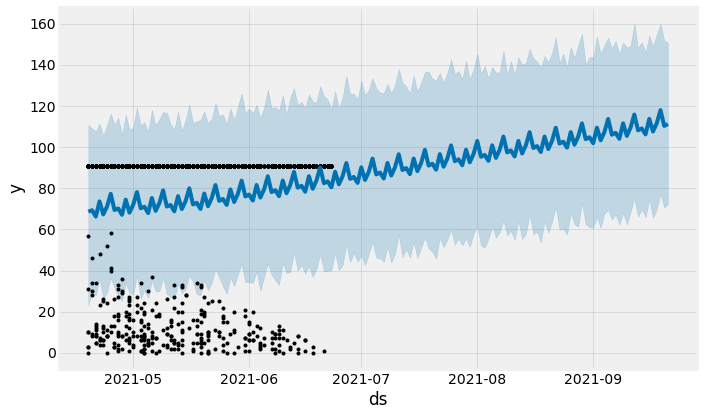

In [452]:
fig1=m.plot(forecast)

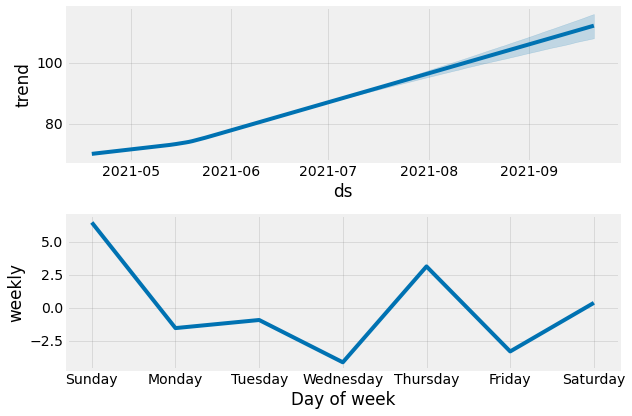

In [453]:
fig2=m.plot_components(forecast)